In [3]:
import functools
import sys
import numpy as np
import tensorflow as tf

from functools import partial
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.regularizers import l2
from keras import backend as K
from keras.layers import Lambda
from keras.layers.merge import concatenate

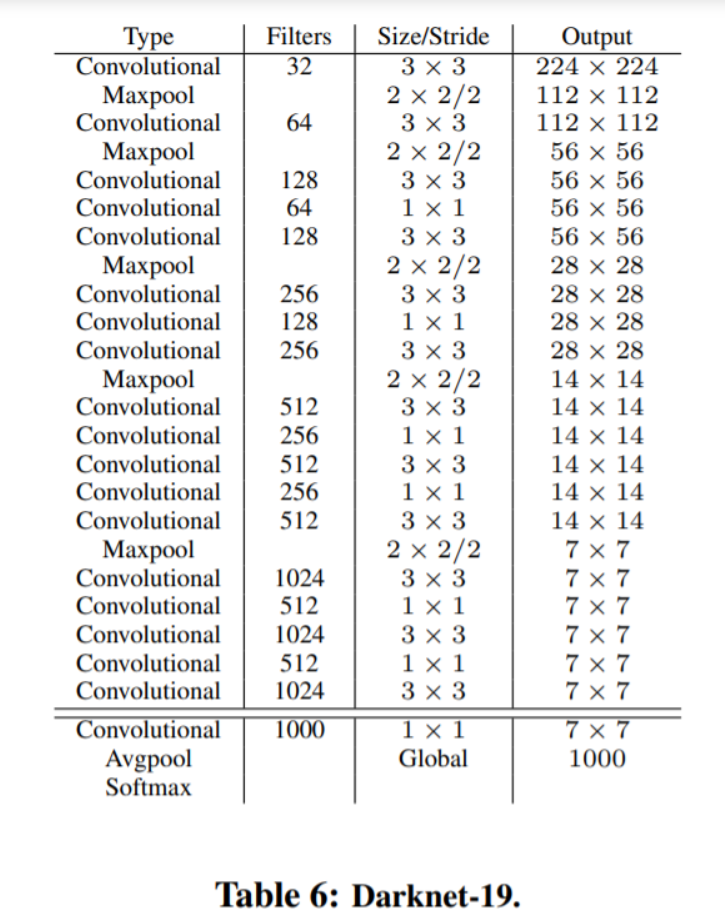

In [4]:
_DarknetConv2D = partial(Conv2D, padding='same') # Trình bao bọc 1 phần Convolution2D với đối số mặc định

In [5]:
@functools.wraps(Conv2D) # functools là một standard Python module cho các hàm bậc cao hơn (các hàm hoạt động trên hoặc trả về các hàm khác). wraps () là một decorator được áp dụng cho wrapper function của một decorator. Nó cập nhật wrapper function để trông giống như wrapped function bằng cách coping attributes như __name__, __doc__ (docstring), v.v.
def DarknetConv2D(*args, **kwargs):
    """Wrapper to set Darknet weight regularizer for Convolution2D."""
    darknet_conv_kwargs = {'kernel_regularizer': l2(5e-4)}
    darknet_conv_kwargs.update(kwargs)
    return _DarknetConv2D(*args, **darknet_conv_kwargs)


In [6]:
def DarknetConv2D_BN_Leaky(*args, **kwargs):
    """Darknet Convolution2D followed by BatchNormalization and LeakyReLU."""
    no_bias_kwargs = {'use_bias': False}
    no_bias_kwargs.update(kwargs)
    return compose(
        DarknetConv2D(*args, **no_bias_kwargs),
        BatchNormalization(),
        LeakyReLU(alpha=0.1))

In [7]:
def bottleneck_block(outer_filters, bottleneck_filters):
    """Bottleneck block of 3x3, 1x1, 3x3 convolutions."""
    return compose(
        DarknetConv2D_BN_Leaky(outer_filters, (3, 3)),
        DarknetConv2D_BN_Leaky(bottleneck_filters, (1, 1)),
        DarknetConv2D_BN_Leaky(outer_filters, (3, 3)))

In [8]:
def bottleneck_x2_block(outer_filters, bottleneck_filters):
    """Bottleneck block of 3x3, 1x1, 3x3, 1x1, 3x3 convolutions."""
    return compose(
        bottleneck_block(outer_filters, bottleneck_filters),
        DarknetConv2D_BN_Leaky(bottleneck_filters, (1, 1)),
        DarknetConv2D_BN_Leaky(outer_filters, (3, 3)))

In [9]:
def darknet_body():
    """Generate first 18 conv layers of Darknet-19."""
    return compose(
        DarknetConv2D_BN_Leaky(32, (3, 3)),
        MaxPooling2D(),
        DarknetConv2D_BN_Leaky(64, (3, 3)),
        MaxPooling2D(),
        bottleneck_block(128, 64),
        MaxPooling2D(),
        bottleneck_block(256, 128),
        MaxPooling2D(),
        bottleneck_x2_block(512, 256),
        MaxPooling2D(),
        bottleneck_x2_block(1024, 512))

In [10]:
def darknet19(inputs):
    """Generate Darknet-19 model for Imagenet classification."""
    body = darknet_body()(inputs)
    logits = DarknetConv2D(1000, (1, 1), activation='softmax')(body)
    return Model(inputs, logits)

In [11]:
voc_anchors = np.array(
    [[1.08, 1.19], [3.42, 4.41], [6.63, 11.38], [9.42, 5.11], [16.62, 10.52]])

voc_classes = [
    "aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat",
    "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person",
    "pottedplant", "sheep", "sofa", "train", "tvmonitor"
]

In [12]:
def space_to_depth_x2(x):
    """Thin wrapper for Tensorflow space_to_depth with block_size=2."""
    import tensorflow as tf
    return tf.space_to_depth(x, block_size=2) #Sắp xếp lại các khối dữ liệu không gian theo chiều sâu. Cụ thể hơn, op này xuất ra một bản sao của tensor đầu vào trong đó các giá trị từ kích thước chiều cao và chiều rộng được chuyển sang kích thước chiều sâu

In [13]:
def space_to_depth_x2_output_shape(input_shape):
    """Determine space_to_depth output shape for block_size=2.
    """
    return (input_shape[0], input_shape[1] // 2, input_shape[2] // 2, 4 *
            input_shape[3]) if input_shape[1] else (input_shape[0], None, None,
                                                    4 * input_shape[3])

In [14]:
def yolo_body(inputs, num_anchors, num_classes):
    """Create YOLO_V2 model CNN body in Keras."""
    darknet = Model(inputs, darknet_body()(inputs))
    conv20 = compose(
        DarknetConv2D_BN_Leaky(1024, (3, 3)),
        DarknetConv2D_BN_Leaky(1024, (3, 3)))(darknet.output)

    conv13 = darknet.layers[43].output
    conv21 = DarknetConv2D_BN_Leaky(64, (1, 1))(conv13)
    conv21_reshaped = Lambda(                                  # Wraps arbitrary expressions as a Layer object.
        space_to_depth_x2,
        output_shape=space_to_depth_x2_output_shape,
        name='space_to_depth')(conv21)

    x = concatenate([conv21_reshaped, conv20])
    x = DarknetConv2D_BN_Leaky(1024, (3, 3))(x)
    x = DarknetConv2D(num_anchors * (num_classes + 5), (1, 1))(x)
    return Model(inputs, x)

In [15]:
def yolo_head(feats, anchors, num_classes):
    """Convert final layer features to bounding box parameters.
    Parameters
    ----------
    feats : tensor
        Final convolutional layer features.
    anchors : array-like
        Anchor box widths and heights.
    num_classes : int
        Number of target classes.
    Returns
    -------
    box_xy : tensor
        x, y box predictions adjusted by spatial location in conv layer.
    box_wh : tensor
        w, h box predictions adjusted by anchors and conv spatial resolution.
    box_conf : tensor
        Probability estimate for whether each box contains any object.
    box_class_pred : tensor
        Probability distribution estimate for each box over class labels.
    """
    num_anchors = len(anchors)
    # Reshape to batch, height, width, num_anchors, box_params.
    anchors_tensor = K.reshape(K.variable(anchors), [1, 1, 1, num_anchors, 2])

    # Dynamic implementation of conv dims for fully convolutional model.
    conv_dims = K.shape(feats)[1:3]  # assuming channels last
    # In YOLO the height index is the inner most iteration.
    conv_height_index = K.arange(0, stop=conv_dims[0])
    conv_width_index = K.arange(0, stop=conv_dims[1])
    conv_height_index = K.tile(conv_height_index, [conv_dims[1]])

    # TODO: Repeat_elements and tf.split doesn't support dynamic splits.
    conv_width_index = K.tile(K.expand_dims(conv_width_index, 0), [conv_dims[0], 1])
    conv_width_index = K.flatten(K.transpose(conv_width_index))
    conv_index = K.transpose(K.stack([conv_height_index, conv_width_index]))
    conv_index = K.reshape(conv_index, [1, conv_dims[0], conv_dims[1], 1, 2])
    conv_index = K.cast(conv_index, K.dtype(feats))
    
    feats = K.reshape(feats, [-1, conv_dims[0], conv_dims[1], num_anchors, num_classes + 5])
    conv_dims = K.cast(K.reshape(conv_dims, [1, 1, 1, 1, 2]), K.dtype(feats))

    box_confidence = K.sigmoid(feats[..., 4:5])
    box_xy = K.sigmoid(feats[..., :2])
    box_wh = K.exp(feats[..., 2:4])
    box_class_probs = K.softmax(feats[..., 5:])

    # Adjust preditions to each spatial grid point and anchor size.
    # Note: YOLO iterates over height index before width index.
    box_xy = (box_xy + conv_index) / conv_dims
    box_wh = box_wh * anchors_tensor / conv_dims

    return box_confidence, box_xy, box_wh, box_class_probs